In [167]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from tqdm import tqdm
from collections import Counter
from statistics import mode

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

In [169]:
import random
random.seed(10)

In [170]:
import os
os.chdir('D:/Documents/Bicocca/1Year/Marketing_Analytics/')
print(os.getcwd())


D:\Documents\Bicocca\1Year\Marketing_Analytics


In [171]:
adresses = pd.read_csv('./data/tbl_addresses.csv')
accounts = pd.read_csv('./data/tbl_customer_accounts.csv')
reviews = pd.read_csv('./data/tbl_customer_reviews.csv')
customers = pd.read_csv('./data/tbl_customers.csv')
labelles_reviews = pd.read_csv('./data/tbl_labelled_reviews.csv')
orders = pd.read_csv('./data/tbl_orders.csv')
products = pd.read_csv('./data/tbl_products.csv')

In [172]:
adresses.head()

,address_id,postal_code,district,region
0,1337,20083.0,MI,LOMBARDIA
1,1347,20090.0,MI,LOMBARDIA
2,1347,20090.0,MI,LOMBARDIA
3,1347,20090.0,MI,LOMBARDIA
4,1347,20090.0,MI,LOMBARDIA


In [173]:
accounts.head()


,customer_id,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date
0,9557,746573,9,premium,1,2023-01-11
1,743090,776971,2,premium,1,2023-01-30
2,813156,791681,45,premium,1,2023-02-08
3,843392,825439,1,premium,1,2023-03-01
4,20476,815010,16,premium,1,2023-02-23


In [174]:
reviews.head()

,review_id,customer_id,review_text
0,1,814256,I have bought several of the Vitality canned d...
1,2,457475,Product arrived labeled as Jumbo Salted Peanut...
2,3,104045,This is a confection that has been around a fe...
3,4,603662,If you are looking for the secret ingredient i...
4,5,739314,Great taffy at a great price. There was a wid...


In [175]:
customers.head()

,customer_id,address_id,birthdate,gender,job_type,email_provider,flag_phone_provided,flag_privacy
0,891057,863914,2001-10-22,F,NaN,yahoo.it,1.0,True
1,655484,639856,2001-04-30,M,NaN,yahoo.it,1.0,False
2,514958,494806,2001-01-01,M,NaN,libero.it,1.0,True
3,398355,377261,2000-03-09,M,NaN,gmail.com,1.0,True
4,23808,20227,1999-11-21,F,NaN,virgilio.it,1.0,True


In [10]:
labelles_reviews.head()


,labelled_reviews_index,review_text,sentiment_label
0,0,I'm no bitters expert but I bought it as a gif...,neutral
1,1,"these are probably great in the right drinks, ...",neutral
2,2,I sent these to my dad for his bday and he sai...,positive
3,3,I purchased these as a gift for family member ...,positive
4,4,My wife bought me this sauce sampler for Chris...,neutral


In [11]:
orders.head()

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime
0,cdab5da0629879968a4a82160e6a33b0,320632,48,31456495,1,0.00,0,2022-10-25T153639
1,8de1ccc0498c7cd9db127f7ba9adaa63,105887,12,31456495,1,0.00,0,2022-09-17T124232
2,2e256585deac5aff98bab6117159ce45,106297,49,31456495,1,0.28,"0,28",2022-11-30T131153
3,6842ec154796c01c77ec0e9877ecd9b8,213862,6,31456495,1,0.00,0,2023-03-31T191205
4,c46137b8ee550e57d7cc3629ab5d3ad2,31486,49,31456495,1,0.00,0,2022-05-02T145309


In [12]:
products.head()

,product_id,product_class
0,35996051,9
1,35980371,14
2,31276196,4
3,31276224,4
4,31456495,4


# RFM model

In [91]:
len(orders.customer_id.unique())

104134

In [92]:
orders['purchase_datetime'] = pd.to_datetime(orders['purchase_datetime'])
orders.sort_values(['customer_id', 'purchase_datetime'], ascending=True, inplace=True)
orders['time_diff'] = orders.groupby('customer_id')['purchase_datetime'].diff().dt.days


In [93]:
orders.head()

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,time_diff
41230,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,0.0,0,2022-10-04 18:28:51,NaN
433805,8fe4346b53d0c781b275a614175804de,23,49,30344384,1,0.0,0,2022-10-04 18:28:51,0.0
623516,8fe4346b53d0c781b275a614175804de,23,49,33794292,1,0.0,0,2022-10-04 18:28:51,0.0
694970,8fe4346b53d0c781b275a614175804de,23,49,33795776,1,0.0,0,2022-10-04 18:28:51,0.0
707532,8fe4346b53d0c781b275a614175804de,23,49,36235381,1,0.0,0,2022-10-04 18:28:51,0.0


In [94]:
#group by order
by_order = orders.groupby(['order_id', 'customer_id']).aggregate({'purchase_datetime':'last', 'gross_price':'sum'}).reset_index()
by_order.sort_values(['customer_id', 'purchase_datetime'], ascending=True, inplace=True)
by_order['time_diff'] = by_order.groupby('customer_id')['purchase_datetime'].diff().dt.days
by_order = by_order[by_order['gross_price'] > 0]


In [95]:
#Find active clients
active_threshold = pd.to_timedelta(90, unit='D')

most_recent_purchase = orders['purchase_datetime'].max()

cutoff_date = most_recent_purchase - active_threshold

active_clients = orders[orders['purchase_datetime'] >= cutoff_date]['customer_id'].unique()

In [96]:
print('all clients = ',len(orders['customer_id'].unique()))
print('active clients = ', len(active_clients))

all clients =  104134
active clients =  45841


In [97]:
by_order_active = by_order[by_order['customer_id'].isin(active_clients)]

In [101]:
by_order_active

,order_id,customer_id,purchase_datetime,gross_price,time_diff,recency
282636,c2ae3673970490406925dcd3f8a4d486,23,2022-10-31 13:07:42,7.54,26.0,182
240429,a55b0fc1b02134f9b5fa4378a74e2e63,23,2022-11-29 16:26:28,1.42,12.0,153
349719,f0fa5d354bd7a6384b18808754840cdf,48,2022-08-11 14:58:17,6.00,NaN,263
101972,46336cc9a409eedb8c4d17fcf42a1b5c,48,2022-08-11 17:58:37,27.00,0.0,263
192489,8472456262ea4c716993ee0d6c29e6ef,48,2022-12-29 19:39:25,33.00,0.0,123
...,...,...,...,...,...,...
299301,ce3936b4eac0f7322e218e280e3b7ffa,929586,2023-04-29 19:43:38,1.11,NaN,2
344539,ed66d870769a3a00a80702e25fe2ef47,930521,2023-04-29 13:03:50,0.59,NaN,2
136326,5dcd7c89e2bb55ed14b4d7e0ddf933c2,934296,2023-04-30 16:24:42,20.00,NaN,1
261627,b411674fcfc94e8cdd32fa3fe324f84e,934317,2023-04-30 17:09:17,9.97,NaN,1


In [99]:
# Calculate Recency, Frequency, and Monetary values
snapshot_date = by_order_active['purchase_datetime'].max() + timedelta(days=1)  
by_order_active['recency'] = (snapshot_date - by_order_active['purchase_datetime']).dt.days
rfm = by_order_active.groupby('customer_id').agg({
    'recency': 'min',  
    'customer_id': 'count',  
    'gross_price': 'mean'  
})

# Rename the columns for clarity
rfm.rename(columns={ 'customer_id': 'frequency', 'gross_price' : 'monetary_value'}, inplace=True)

In [102]:
# Create segments based on quartiles
quartiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quartiles = quartiles.to_dict()

def r_score(x, column):
    if x <= quartiles[column][0.25]:
        return 4
    elif x <= quartiles[column][0.50]:
        return 3
    elif x <= quartiles[column][0.75]:
        return 2
    else:
        return 1

def fm_score(x, column):
    if x <= quartiles[column][0.25]:
        return 1
    elif x <= quartiles[column][0.50]:
        return 2
    elif x <= quartiles[column][0.75]:
        return 3
    else:
        return 4

rfm['R_score'] = rfm['recency'].apply(r_score, args=('recency',))
rfm['F_score'] = rfm['frequency'].apply(fm_score, args=('frequency',))
rfm['M_score'] = rfm['monetary_value'].apply(fm_score, args=('monetary_value',))

# Combine the scores into an RFM segment
rfm['RFM_segment'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# Calculate RFM score
rfm['RFM_score'] = rfm[['R_score', 'F_score', 'M_score']].sum(axis=1)

In [104]:
rfm_counts = rfm.groupby('RFM_score')['M_score'].agg('count').reset_index()
rfm_counts.rename(columns={ 'M_score': 'count'}, inplace=True)

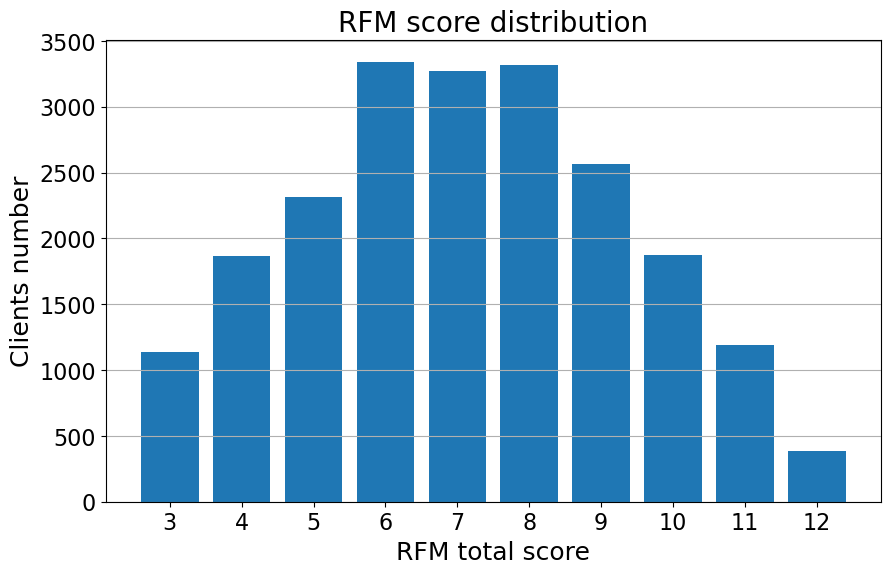

In [105]:
plt.figure(figsize=(10,6))

plt.bar(rfm_counts['RFM_score'], rfm_counts['count'])


plt.xlabel("RFM total score", size=18)
plt.ylabel("Clients number", size=18)

plt.yticks(size=16)


plt.xticks(rfm_counts['RFM_score'],rfm_counts['RFM_score'], size=16)
plt.grid(axis='y')
plt.title("RFM score distribution",fontsize=20)

plt.show()

In [106]:
rfm_counts_segment = rfm.groupby('RFM_segment').aggregate({'M_score':'count', 'RFM_score': 'max'}).reset_index()
rfm_counts_segment.rename(columns={ 'M_score': 'count'}, inplace=True)

In [107]:
rfm_counts_segment = rfm_counts_segment.sort_values('RFM_score').reset_index(drop = True)

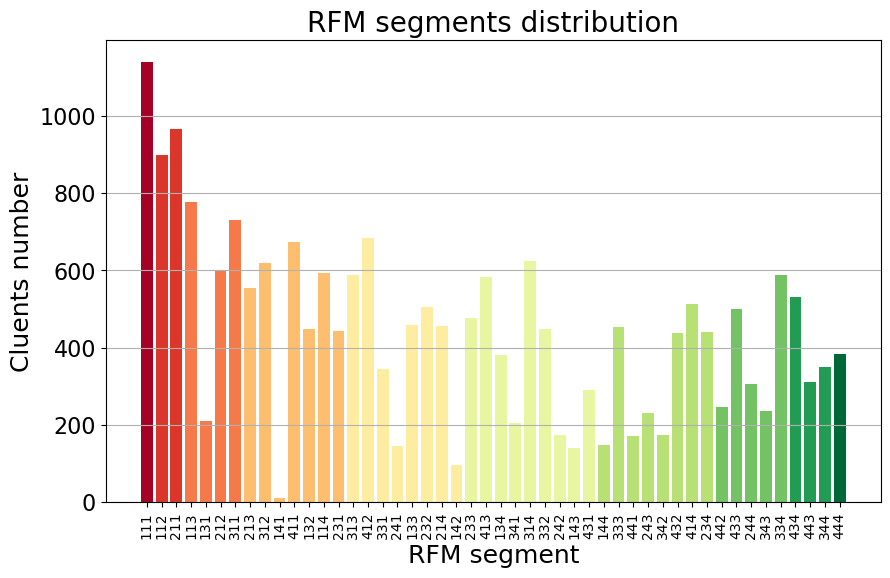

In [108]:
my_cmap = plt.get_cmap("RdYlGn")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))


plt.figure(figsize=(10,6))

plt.bar(rfm_counts_segment['RFM_segment'], rfm_counts_segment['count'],\
         color = my_cmap(rescale(rfm_counts_segment['RFM_score'] )))


plt.xlabel("RFM segment", size=18)
plt.ylabel("Cluents number", size=18)

plt.yticks(size=16)


plt.xticks(rfm_counts_segment['RFM_segment'],rfm_counts_segment['RFM_segment'], size=10, rotation = 90)
plt.grid(axis='y')
plt.title("RFM segments distribution",fontsize=20)

plt.show()

In [109]:
hv_customers = rfm[rfm['RFM_score']>= 10].index.tolist()
len(hv_customers)

3453

### Churn model

In [110]:
#
orders_buy = orders[orders['direction'] == 1]
orders_buy = orders_buy.merge(products, on = 'product_id', how = 'left')
by_order = orders_buy.groupby(['order_id', 'customer_id']).aggregate({'purchase_datetime':'last', 'gross_price':'sum'}).reset_index()
by_order.sort_values(['customer_id', 'purchase_datetime'], ascending=True, inplace=True)
by_order['time_diff'] = by_order.groupby('customer_id')['purchase_datetime'].diff().dt.days

#add product categories
categories = orders_buy.groupby(['order_id', 'customer_id'])['product_class'].apply(list).reset_index()
by_order = by_order.merge(categories, on = ['order_id','customer_id'], how = 'left')

In [111]:
average_days_between_purchases = by_order.groupby('customer_id')['time_diff'].mean()

sorted_values = average_days_between_purchases.sort_values().dropna().reset_index()
cumulative_prob = sorted_values.index / len(sorted_values)

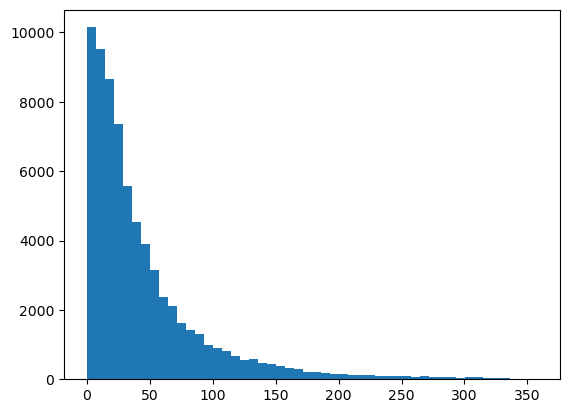

In [112]:
plt.hist(sorted_values['time_diff'], bins=50)
plt.show()



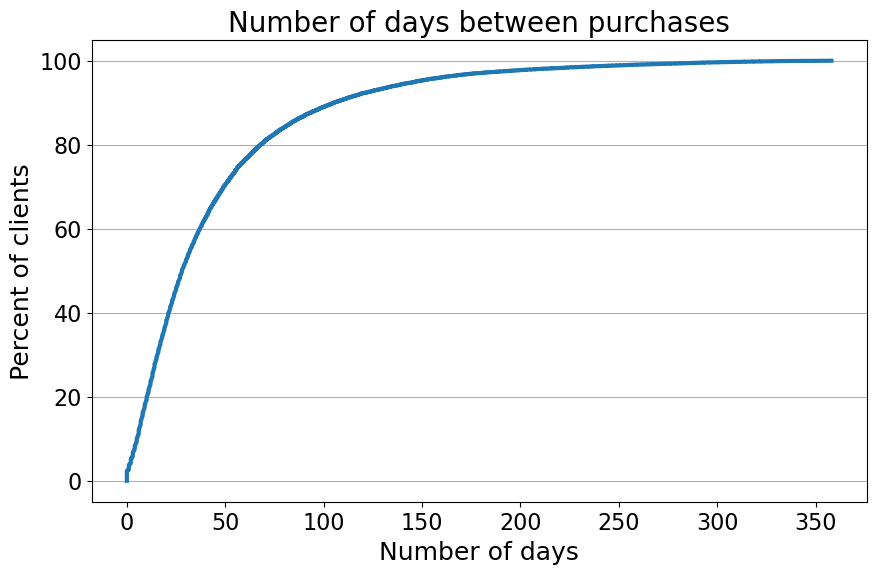

In [113]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt


ecdf = ECDF(sorted_values['time_diff'])

plt.figure(figsize=(10,6))

plt.plot(ecdf.x,ecdf.y * 100, linewidth = 3)



plt.xlabel("Number of days", size=18)
plt.ylabel("Percent of clients", size=18)

plt.yticks(size=16)

#plt.legend(fontsize=16)

plt.xticks(size=16)
plt.grid(axis='y')
plt.title("Number of days between purchases",fontsize=20)

plt.show()


In [114]:
print(by_order['purchase_datetime'].min(), " - ", by_order['purchase_datetime'].max())

2022-05-01 07:19:05  -  2023-04-30 21:11:13


In [115]:
import datetime
import statistics

last_date = by_order['purchase_datetime'].max()
holdout = 90
reference_date = datetime.date(2022, 10, 15)
end_holdout = reference_date + datetime.timedelta(holdout)
before_ref_date = reference_date - datetime.timedelta(10)

reference_date = np.datetime64(reference_date)
end_holdout = np.datetime64(end_holdout)
before_ref_date = np.datetime64(before_ref_date)

In [116]:
#select data

#data before ref date
before_ref =  by_order[by_order['purchase_datetime'] < reference_date ]
#filter to keep only customers who were perchasing 10 days before
has_purch = before_ref.groupby(['customer_id']).aggregate({'purchase_datetime' : 'max'}).reset_index()
has_purch = has_purch[has_purch['purchase_datetime'] >= before_ref_date]['customer_id'].unique()
before_ref = before_ref[before_ref['customer_id'].isin(has_purch)]

#data during holdout
after_ref =  by_order[(by_order['purchase_datetime'] >= reference_date) & (by_order['purchase_datetime'] < end_holdout)]
after_ref_clients = after_ref['customer_id'].unique().tolist()

In [117]:
data_to_train = pd.DataFrame(columns=['customer_id', 'last_purch_day', 'total_orders', 'money_spent', 'common_class',\
    'cl1',  'cl2',  'cl3',  'cl4',  'cl5',  'cl6',  'cl7',  'cl8',  'cl9', 'cl10', 'cl11','cl12', 'cl13', 'cl14'])

In [118]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def create_features(client_id):
    one_client = before_ref[before_ref['customer_id'] == client_id]
    days_before_ref = (reference_date - one_client['purchase_datetime'].tolist()[-1]).days
    orders_num = len(one_client)
    money_spent = one_client['gross_price'].sum()   
    most_common_class = statistics.mode(flatten(one_client['product_class'].tolist()))

    categories_all = pd.DataFrame()
    categories_all['category'] = np.sort(products['product_class'].unique())

    categories_purchases = pd.DataFrame.from_dict(Counter(flatten(one_client['product_class'].tolist())), orient='index')\
        .reset_index().rename(columns={'index': 'category', 0: 'count'})
    categories_all = categories_all.merge(categories_purchases, on = 'category', how = 'left').fillna(0)

    categories_list = categories_all['count'].tolist()

    list_with_values = [client_id, days_before_ref, orders_num, money_spent, most_common_class]
    list_with_values.extend(categories_list)
    return list_with_values

In [119]:
for client_id in tqdm(before_ref['customer_id'].unique()):
    list_with_values = create_features(client_id)
    data_to_train.loc[len(data_to_train)] = list_with_values

  0%|          | 0/8359 [00:00<?, ?it/s]

100%|██████████| 8359/8359 [00:55<00:00, 151.75it/s]


In [120]:
# make target column
data_to_train['customer_id'] = data_to_train['customer_id'].astype('int')
clents_not_churned = pd.DataFrame(after_ref_clients).rename(columns={ 0: 'customer_id'})
clents_not_churned['churn'] = 0

data_to_train = data_to_train.merge(clents_not_churned, on = "customer_id", how = "left").fillna(1)
data_to_train['churn'] = data_to_train['churn'].astype('int')
data_to_train['common_class'] = data_to_train['common_class'].astype('int')

data_to_train['churn'] = data_to_train['churn'].astype('category')
data_to_train['common_class'] = data_to_train['common_class'].astype('category')

In [121]:
Counter(data_to_train['churn'])

Counter({1: 3223, 0: 5136})

In [122]:
customers_features = customers[['customer_id', 'address_id', 'birthdate', 'gender']]
customers_features = customers_features.merge(accounts[['customer_id','favorite_store', 'loyalty_type', 'loyatlty_status', 'activation_date']], on = 'customer_id', how = 'left')

customers_features['birthdate'] = pd.to_datetime(customers_features['birthdate'])
customers_features['activation_date'] = pd.to_datetime(customers_features['activation_date'])
customers_features['age'] = ((reference_date - customers_features['birthdate']) / pd.Timedelta(days=1) / 365).astype(int)
#errors in data
#customers_features['activated'] = (reference_date - customers_features['activation_date']) / pd.Timedelta(days=1)
customers_features = customers_features.merge(adresses[['address_id', 'region']], on = 'address_id', how = 'left')
customers_features = customers_features.drop(['birthdate', 'address_id', 'activation_date'], axis = 1)

In [123]:
data_to_train_features = data_to_train.merge(customers_features, on = 'customer_id', how = 'left')

In [124]:
data_to_train_features['favorite_store'] = data_to_train_features['favorite_store'].astype('category')
data_to_train_features['loyatlty_status'] = data_to_train_features['loyatlty_status'].astype('category')

data_to_train_features['gender'] = data_to_train_features['gender'].astype('category')
data_to_train_features['loyalty_type'] = data_to_train_features['loyalty_type'].astype('category')
data_to_train_features['region'] = data_to_train_features['region'].astype('category')


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#One-hot-encode the categorical columns.
#Unfortunately outputs an array instead of dataframe.

data_to_train_features['gender'] = le.fit_transform(data_to_train_features['gender'])
data_to_train_features['loyalty_type'] = le.fit_transform(data_to_train_features['loyalty_type'])
data_to_train_features['region'] = le.fit_transform(data_to_train_features['region'])

In [125]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data_to_train_features, test_size=0.3, random_state=42, stratify=data_to_train_features['churn'])
y_train = data_train['churn']
y_test = data_test['churn']
data_train_model = data_train.drop(['churn'], axis=1)
data_train_model = data_train_model.drop(['customer_id'], axis=1)
data_test_model = data_test.drop(['churn'], axis=1)
data_test_model = data_test_model.drop(['customer_id'], axis=1)


In [45]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(data_train_model, y_train)

# Evaluate the model on the train set
y_pred_proba = tree.predict_proba(data_train_model)[:, 1]
data_train['y_pred_proba_dtr'] = y_pred_proba
y_pred = tree.predict(data_train_model)
data_train['y_pred_dtr'] = y_pred


# Evaluate the model on test set
y_pred_proba_test = tree.predict_proba(data_test_model)[:, 1]
data_test['y_pred_proba_dtr'] = y_pred_proba_test

y_pred_test = tree.predict(data_test_model)
data_test['y_pred_dtr'] = y_pred_test

In [46]:
import shap

explainer = shap.Explainer(tree.predict, data_test_model)
# Calculates the SHAP values - It takes some time
shap_values = explainer(data_test_model)

Permutation explainer: 4036it [01:04, 53.99it/s]                          


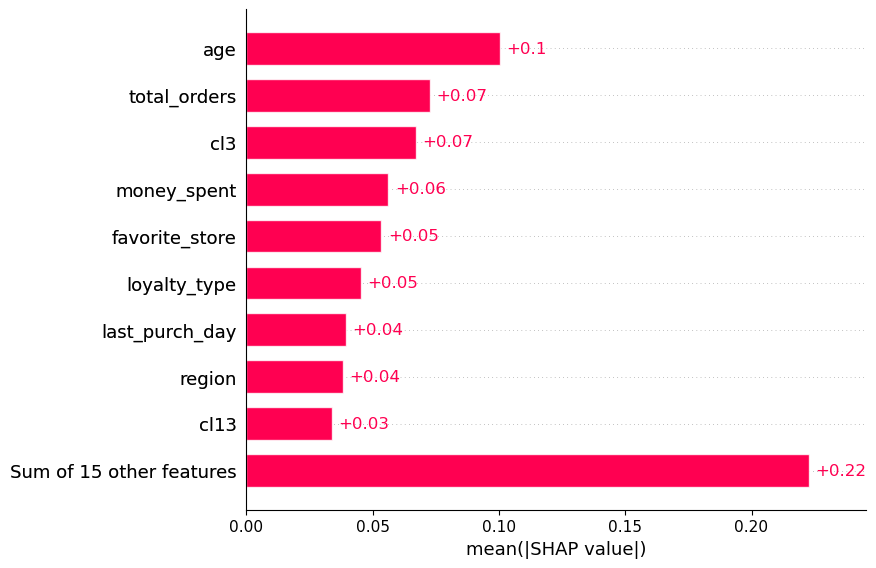

In [47]:
shap.plots.bar(shap_values)


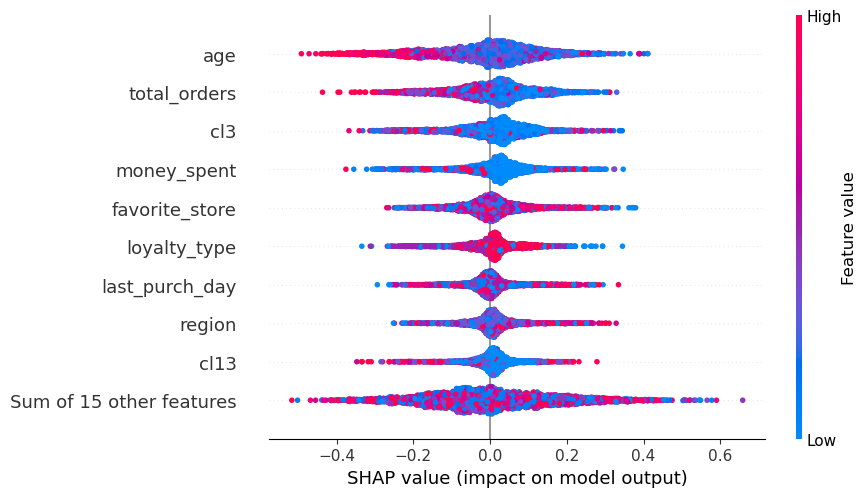

In [48]:
shap.plots.beeswarm(shap_values)


In [126]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(data_train_model, y_train)

# Evaluate the model on the test set
y_pred_proba_rfc = rfc.predict_proba(data_train_model)[:,1]
data_train['y_pred_proba_rfc'] = y_pred_proba_rfc

y_pred_rfc = rfc.predict(data_train_model)
data_train['y_pred_rfc'] = y_pred_rfc

# Evaluate the model on the test set
y_pred_test_proba_rfc = rfc.predict_proba(data_test_model)[:,1]
data_test['y_pred_proba_rfc'] = y_pred_test_proba_rfc

y_pred_test_rfc = rfc.predict(data_test_model)
data_test['y_pred_rfc'] = y_pred_test_rfc

In [50]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(data_train_model, y_train)

# Evaluate the model on the train set
y_pred_proba_mlp = mlp.predict_proba(data_train_model)[:,1]
data_train['y_pred_proba_mlp'] = y_pred_proba_mlp

y_pred_mlp = mlp.predict(data_train_model)
data_train['y_pred_mlp'] = y_pred_mlp


# Evaluate the model on the test set
y_pred_test_proba_mlp = mlp.predict_proba(data_test_model)[:,1]
data_test['y_pred_proba_mlp'] = y_pred_test_proba_mlp

y_pred_test_mlp = mlp.predict(data_test_model)
data_test['y_pred_mlp'] = y_pred_test_mlp

In [51]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42).fit(data_train_model, y_train)

# Evaluate the model on the train set
y_pred_proba_log = clf.predict_proba(data_train_model)[:,1]
data_train['y_pred_proba_log'] = y_pred_proba_log

y_pred_log = clf.predict(data_train_model)
data_train['y_pred_log'] = y_pred_log


# Evaluate the model on the test set
y_pred_test_proba_log = clf.predict_proba(data_test_model)[:,1]
data_test['y_pred_proba_log'] = y_pred_test_proba_log

y_pred_test_log = clf.predict(data_test_model)
data_test['y_pred_log'] = y_pred_test_log

In [185]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from scipy.stats import mode

In [53]:
def calc_metrics(y_true, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred)
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred)
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred)
    # Calculate naive accuracy
    most_common = y_true.mode().iloc[0]
    naive_preds = [most_common] * len(y_true)
    naive_accuracy = accuracy_score(y_true, naive_preds)
    specificity =  recall_score(y_true, y_pred, pos_label=0)

    return accuracy, precision, recall, naive_accuracy, specificity

In [54]:
accuracy_train, accuracy_test = [], []
precision_train, precision_test = [], []
specificity_train, specificity_test = [], []
recall_train, recall_test = [], []
naive_train, naive_test = [], []
models = []

for model in ['dtr', 'rfc', 'mlp', 'log']:
    # train
    accuracy, precision, recall, naive_accuracy, specificity = calc_metrics(data_train['churn'],data_train['y_pred_'+model] )
    models.append(model)
    accuracy_train.append(accuracy)
    precision_train.append(precision)
    specificity_train.append(specificity)
    recall_train.append(recall)
    naive_train.append(naive_accuracy)


    # test
    accuracy, precision, recall, naive_accuracy, specificity = calc_metrics(data_test['churn'],data_test['y_pred_'+model] )

    accuracy_test.append(accuracy)
    precision_test.append(precision)
    specificity_test.append(specificity)
    recall_test.append(recall)
    naive_test.append(naive_accuracy)

In [55]:
models_comparison = pd.DataFrame()
models_comparison['model'] = models
models_comparison['accuracy_train'] = accuracy_train
models_comparison['precision_train'] = precision_train
models_comparison['recall_train'] = recall_train
models_comparison['naive_train'] = naive_train
models_comparison['accuracy_test'] = accuracy_test
models_comparison['precision_test'] = precision_test
models_comparison['recall_test'] = recall_test
models_comparison['naive_test'] = naive_test

In [56]:
models_comparison

,model,accuracy_train,precision_train,recall_train,naive_train,accuracy_test,precision_test,recall_test,naive_test
0,dtr,0.999894,0.999723,1.000000,0.616357,0.777695,0.702551,0.729328,0.616357
1,rfc,0.999894,0.999723,1.000000,0.616357,0.815861,0.817179,0.669897,0.616357
2,mlp,0.673181,0.650365,0.320321,0.616357,0.651549,0.595946,0.284884,0.616357
3,log,0.643760,0.564759,0.311462,0.616357,0.640149,0.552863,0.324289,0.616357


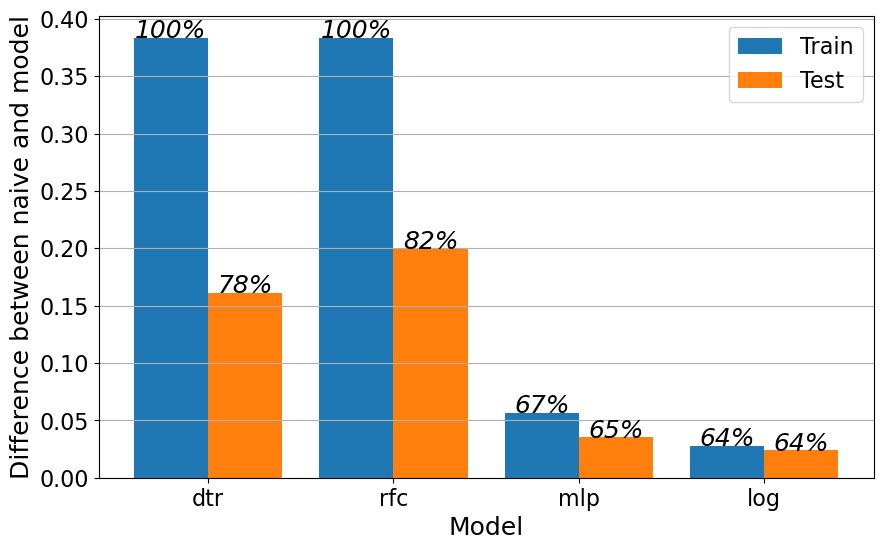

In [62]:
plt.figure(figsize=(10,6))
x = np.arange(len(models_comparison))

plt.bar(x-0.2, models_comparison['accuracy_train'] - models_comparison['naive_train'], width = 0.4)
plt.bar(x+0.2, models_comparison['accuracy_test'] - models_comparison['naive_test'], width = 0.4)

for i in range(len(x)):
    plt.text(x[i]-0.2, (models_comparison['accuracy_train'] - models_comparison['naive_train'])[i], str(int(round(models_comparison['accuracy_train'][i],2)*100)) + '%', horizontalalignment='center', style='italic', size=18)
    plt.text(x[i]+0.2, (models_comparison['accuracy_test'] - models_comparison['naive_test'])[i], str(int(round(models_comparison['accuracy_test'][i],2)*100)) + '%', horizontalalignment='center', style='italic', size=18)

plt.xticks(x, models_comparison['model'], size=16)
plt.yticks(size=16)

plt.xlabel("Model", size=18)
plt.ylabel("Difference between naive and model", size=18)
plt.grid(axis='y')
plt.legend(["Train", "Test"], fontsize=16)


### bootstrap to find optimal model

In [88]:
dtr_acc_train_boot = []
rfc_acc_train_boot = []
mlp_acc_train_boot = []
log_acc_train_boot = []

dtr_acc_test_boot = []
rfc_acc_test_boot = []
mlp_acc_test_boot = []
log_acc_test_boot = []
dates = []

In [78]:
from random import randrange


def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + datetime.timedelta(seconds=random_second)

In [86]:
import datetime
import statistics

In [89]:
for _ in tqdm(range(50)):
    last_date = by_order['purchase_datetime'].max()
    holdout = 90
    d1 = datetime.date(2022, 8, 15)
    d2 = datetime.date(2023, 1, 30)
    reference_date = random_date(d1, d2)
    end_holdout = reference_date + datetime.timedelta(holdout)
    before_ref_date = reference_date - datetime.timedelta(10)
    dates.append(reference_date)
    reference_date = np.datetime64(reference_date)
    end_holdout = np.datetime64(end_holdout)
    before_ref_date = np.datetime64(before_ref_date)
    #select data

    #data before ref date
    before_ref =  by_order[by_order['purchase_datetime'] < reference_date ]
    #filter to keep only customers who were perchasing 75 days before
    has_purch = before_ref.groupby(['customer_id']).aggregate({'purchase_datetime' : 'max'}).reset_index()
    has_purch = has_purch[has_purch['purchase_datetime'] >= before_ref_date]['customer_id'].unique()
    before_ref = before_ref[before_ref['customer_id'].isin(has_purch)]

    #data during holdout
    after_ref =  by_order[(by_order['purchase_datetime'] >= reference_date) & (by_order['purchase_datetime'] < end_holdout)]
    after_ref_clients = after_ref['customer_id'].unique().tolist()
    data_to_train = pd.DataFrame(columns=['customer_id', 'last_purch_day', 'total_orders', 'money_spent', 'common_class',\
        'cl1',  'cl2',  'cl3',  'cl4',  'cl5',  'cl6',  'cl7',  'cl8',  'cl9', 'cl10', 'cl11','cl12', 'cl13', 'cl14'])
    def flatten(l):
        return [item for sublist in l for item in sublist]

    def create_features(client_id):
        one_client = before_ref[before_ref['customer_id'] == client_id]
        days_before_ref = (reference_date - one_client['purchase_datetime'].tolist()[-1]).days
        orders_num = len(one_client)
        money_spent = one_client['gross_price'].sum()
        most_common_class = statistics.mode(flatten(one_client['product_class'].tolist()))

        categories_all = pd.DataFrame()
        categories_all['category'] = np.sort(products['product_class'].unique())

        categories_purchases = pd.DataFrame.from_dict(Counter(flatten(one_client['product_class'].tolist())), orient='index')\
            .reset_index().rename(columns={'index': 'category', 0: 'count'})
        categories_all = categories_all.merge(categories_purchases, on = 'category', how = 'left').fillna(0)

        categories_list = categories_all['count'].tolist()

        list_with_values = [client_id, days_before_ref, orders_num, money_spent, most_common_class]
        list_with_values.extend(categories_list)
        return list_with_values
    for client_id in before_ref['customer_id'].unique():
        list_with_values = create_features(client_id)
        data_to_train.loc[len(data_to_train)] = list_with_values
    # make target column
    data_to_train['customer_id'] = data_to_train['customer_id'].astype('int')
    clents_not_churned = pd.DataFrame(after_ref_clients).rename(columns={ 0: 'customer_id'})
    clents_not_churned['churn'] = 0

    data_to_train = data_to_train.merge(clents_not_churned, on = "customer_id", how = "left").fillna(1)
    data_to_train['churn'] = data_to_train['churn'].astype('int')
    data_to_train['common_class'] = data_to_train['common_class'].astype('int')

    data_to_train['churn'] = data_to_train['churn'].astype('category')
    data_to_train['common_class'] = data_to_train['common_class'].astype('category')
    customers_features = customers[['customer_id', 'address_id', 'birthdate', 'gender']]
    customers_features = customers_features.merge(accounts[['customer_id','favorite_store', 'loyalty_type', 'loyatlty_status', 'activation_date']], on = 'customer_id', how = 'left')

    customers_features['birthdate'] = pd.to_datetime(customers_features['birthdate'])
    customers_features['activation_date'] = pd.to_datetime(customers_features['activation_date'])
    customers_features['age'] = ((reference_date - customers_features['birthdate']) / pd.Timedelta(days=1) / 365).astype(int)
    #errors in data
    #customers_features['activated'] = (reference_date - customers_features['activation_date']) / pd.Timedelta(days=1)
    customers_features = customers_features.merge(adresses[['address_id', 'region']], on = 'address_id', how = 'left')
    customers_features = customers_features.drop(['birthdate', 'address_id', 'activation_date'], axis = 1)
    data_to_train_features = data_to_train.merge(customers_features, on = 'customer_id', how = 'left')
    data_to_train_features['favorite_store'] = data_to_train_features['favorite_store'].astype('category')
    data_to_train_features['loyatlty_status'] = data_to_train_features['loyatlty_status'].astype('category')

    data_to_train_features['gender'] = data_to_train_features['gender'].astype('category')
    data_to_train_features['loyalty_type'] = data_to_train_features['loyalty_type'].astype('category')
    data_to_train_features['region'] = data_to_train_features['region'].astype('category')


    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()

    #One-hot-encode the categorical columns.
    #Unfortunately outputs an array instead of dataframe.

    data_to_train_features['gender'] = le.fit_transform(data_to_train_features['gender'])
    data_to_train_features['loyalty_type'] = le.fit_transform(data_to_train_features['loyalty_type'])
    data_to_train_features['region'] = le.fit_transform(data_to_train_features['region'])
    from sklearn.model_selection import train_test_split

    data_train, data_test = train_test_split(data_to_train_features, test_size=0.3, random_state=42, stratify=data_to_train_features['churn'])
    y_train = data_train['churn']
    y_test = data_test['churn']
    data_train_model = data_train.drop(['churn'], axis=1)
    data_train_model = data_train_model.drop(['customer_id'], axis=1)
    data_test_model = data_test.drop(['churn'], axis=1)
    data_test_model = data_test_model.drop(['customer_id'], axis=1)

    from sklearn.tree import DecisionTreeClassifier

    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(data_train_model, y_train)

    # Evaluate the model on the train set
    y_pred_proba = tree.predict_proba(data_train_model)[:, 1]
    data_train['y_pred_proba_dtr'] = y_pred_proba
    y_pred = tree.predict(data_train_model)
    data_train['y_pred_dtr'] = y_pred


    # Evaluate the model on test set
    y_pred_proba_test = tree.predict_proba(data_test_model)[:, 1]
    data_test['y_pred_proba_dtr'] = y_pred_proba_test

    y_pred_test = tree.predict(data_test_model)
    data_test['y_pred_dtr'] = y_pred_test
    from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier()
    rfc.fit(data_train_model, y_train)

    # Evaluate the model on the test set
    y_pred_proba_rfc = rfc.predict_proba(data_train_model)[:,1]
    data_train['y_pred_proba_rfc'] = y_pred_proba_rfc

    y_pred_rfc = rfc.predict(data_train_model)
    data_train['y_pred_rfc'] = y_pred_rfc

    # Evaluate the model on the test set
    y_pred_test_proba_rfc = rfc.predict_proba(data_test_model)[:,1]
    data_test['y_pred_proba_rfc'] = y_pred_test_proba_rfc

    y_pred_test_rfc = rfc.predict(data_test_model)
    data_test['y_pred_rfc'] = y_pred_test_rfc
    from sklearn.neural_network import MLPClassifier

    mlp = MLPClassifier()
    mlp.fit(data_train_model, y_train)

    # Evaluate the model on the train set
    y_pred_proba_mlp = mlp.predict_proba(data_train_model)[:,1]
    data_train['y_pred_proba_mlp'] = y_pred_proba_mlp

    y_pred_mlp = mlp.predict(data_train_model)
    data_train['y_pred_mlp'] = y_pred_mlp


    # Evaluate the model on the test set
    y_pred_test_proba_mlp = mlp.predict_proba(data_test_model)[:,1]
    data_test['y_pred_proba_mlp'] = y_pred_test_proba_mlp

    y_pred_test_mlp = mlp.predict(data_test_model)
    data_test['y_pred_mlp'] = y_pred_test_mlp
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=42).fit(data_train_model, y_train)

    # Evaluate the model on the train set
    y_pred_proba_log = clf.predict_proba(data_train_model)[:,1]
    data_train['y_pred_proba_log'] = y_pred_proba_log

    y_pred_log = clf.predict(data_train_model)
    data_train['y_pred_log'] = y_pred_log


    # Evaluate the model on the test set
    y_pred_test_proba_log = clf.predict_proba(data_test_model)[:,1]
    data_test['y_pred_proba_log'] = y_pred_test_proba_log

    y_pred_test_log = clf.predict(data_test_model)
    data_test['y_pred_log'] = y_pred_test_log
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from scipy.stats import mode
    def calc_metrics(y_true, y_pred):
        # accuracy: (tp + tn) / (p + n)
        accuracy = accuracy_score(y_true, y_pred)
        # precision tp / (tp + fp)
        precision = precision_score(y_true, y_pred)
        # recall: tp / (tp + fn)
        recall = recall_score(y_true, y_pred)
        # Calculate naive accuracy
        most_common = y_true.mode().iloc[0]
        naive_preds = [most_common] * len(y_true)
        naive_accuracy = accuracy_score(y_true, naive_preds)
        specificity =  recall_score(y_true, y_pred, pos_label=0)

        return accuracy, precision, recall, naive_accuracy, specificity



    model = 'dtr'
    accuracy, precision, recall, naive_accuracy, specificity = calc_metrics(data_train['churn'],data_train['y_pred_'+model] )
    accuracy_test, precision, recall, naive_accuracy, specificity = calc_metrics(data_test['churn'],data_test['y_pred_'+model] )
    dtr_acc_train_boot.append(accuracy)
    dtr_acc_test_boot.append(accuracy_test)

    model = 'rfc'
    accuracy, precision, recall, naive_accuracy, specificity = calc_metrics(data_train['churn'],data_train['y_pred_'+model] )
    accuracy_test, precision, recall, naive_accuracy, specificity = calc_metrics(data_test['churn'],data_test['y_pred_'+model] )
    rfc_acc_train_boot.append(accuracy)
    rfc_acc_test_boot.append(accuracy_test)

    model = 'mlp'
    accuracy, precision, recall, naive_accuracy, specificity = calc_metrics(data_train['churn'],data_train['y_pred_'+model] )
    accuracy_test, precision, recall, naive_accuracy, specificity = calc_metrics(data_test['churn'],data_test['y_pred_'+model] )
    mlp_acc_train_boot.append(accuracy)
    mlp_acc_test_boot.append(accuracy_test)

    model = 'log'
    accuracy, precision, recall, naive_accuracy, specificity = calc_metrics(data_train['churn'],data_train['y_pred_'+model] )
    accuracy_test, precision, recall, naive_accuracy, specificity = calc_metrics(data_test['churn'],data_test['y_pred_'+model] )
    log_acc_train_boot.append(accuracy)
    log_acc_test_boot.append(accuracy_test)


100%|██████████| 50/50 [30:31<00:00, 36.62s/it]


Text(0, 0.5, 'Accuracy')

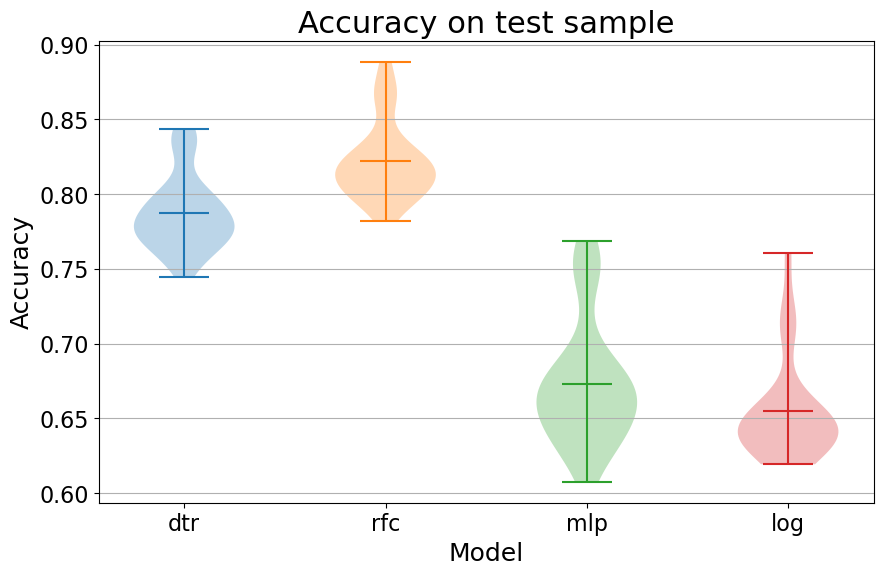

In [95]:
import matplotlib.patches as mpatches
plt.figure(figsize=(10,6))
violin_parts = plt.violinplot(dtr_acc_test_boot, positions=[1], showmeans = True)
violin_parts = plt.violinplot(rfc_acc_test_boot, positions=[2], showmeans = True)
violin_parts = plt.violinplot(mlp_acc_test_boot, positions=[3], showmeans = True)
violin_parts = plt.violinplot(log_acc_test_boot, positions=[4], showmeans = True)
plt.grid(axis='y')

plt.title('Accuracy on test sample', size=22)
plt.xticks([1,2,3,4], ['dtr', 'rfc', 'mlp', 'log'] , size=16)
plt.yticks(size=16)
plt.xlabel("Model" , size=18)
plt.ylabel("Accuracy" , size=18)

# MBA

In [188]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [128]:
data_for_association_rules = orders.merge(products, on = 'product_id', how = 'left')
data_for_association_rules.head()

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,time_diff,product_class
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,0.0,0,2022-10-04 18:28:51,NaN,6
1,8fe4346b53d0c781b275a614175804de,23,49,30344384,1,0.0,0,2022-10-04 18:28:51,0.0,6
2,8fe4346b53d0c781b275a614175804de,23,49,33794292,1,0.0,0,2022-10-04 18:28:51,0.0,6
3,8fe4346b53d0c781b275a614175804de,23,49,33795776,1,0.0,0,2022-10-04 18:28:51,0.0,6
4,8fe4346b53d0c781b275a614175804de,23,49,36235381,1,0.0,0,2022-10-04 18:28:51,0.0,6


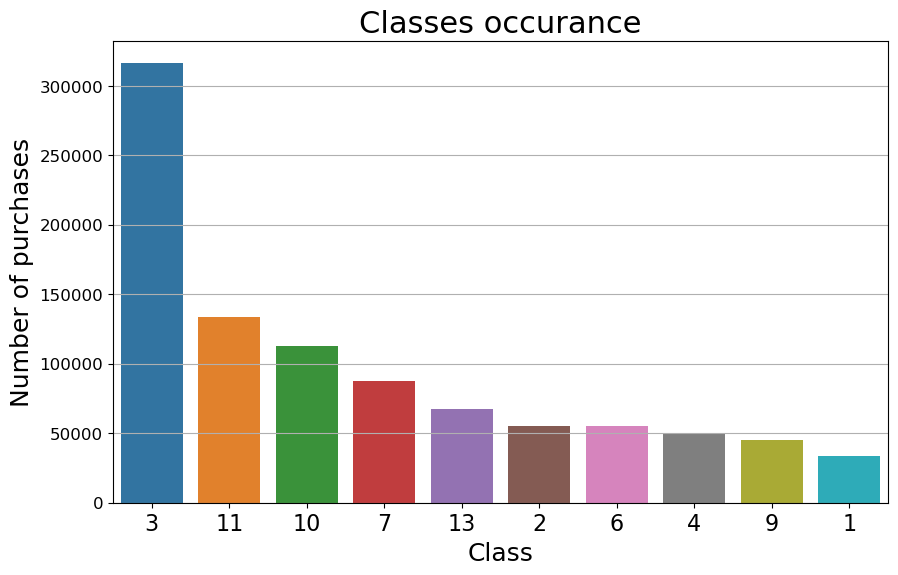

In [129]:
plt.figure(figsize=(10,6))
sns.countplot(x = 'product_class', data = data_for_association_rules, order = data_for_association_rules['product_class'].value_counts().iloc[:10].index)
plt.xticks(size=16)
plt.yticks(size=12)
plt.xlabel("Class" , size=18)
plt.ylabel("Number of purchases" , size=18)
plt.title('Classes occurance', size=22)
plt.grid(axis='y')
plt.show()


In [130]:
def fit_association_rules(data_for_association_rules, group_by, category,  min_support=0.05, min_threshold=1.0):
    transactions = data_for_association_rules.groupby([group_by])[category].apply(list).tolist()
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    transaction_df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = apriori(transaction_df, min_support=min_support, use_colnames=True)
    ass_rules = association_rules(frequent_itemsets, metric='lift', min_threshold=min_threshold)
    return frequent_itemsets, ass_rules

In [140]:
frequent_itemsets_user_item ,ass_rules_user_item = fit_association_rules(\
    data_for_association_rules, group_by =  'customer_id', category = 'product_id', min_support=0.1, min_threshold=1.0)
    
frequent_itemsets_user_group ,ass_rules_user_group = fit_association_rules(\
    data_for_association_rules, group_by =  'customer_id', category = 'product_class', min_support=0.1, min_threshold=1.0)


In [142]:
ass_rules_user_group.sort_values(by=['lift'], ascending=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
81,(4),"(10, 11)",0.277681,0.263622,0.128229,0.461786,1.751698,0.055026,1.368188,0.594094
76,"(10, 11)",(4),0.263622,0.277681,0.128229,0.486413,1.751698,0.055026,1.406420,0.582751
40,"(11, 3)",(4),0.255930,0.277681,0.122534,0.478781,1.724215,0.051468,1.385828,0.564498
45,(4),"(11, 3)",0.277681,0.255930,0.122534,0.441278,1.724215,0.051468,1.331736,0.581496
34,"(10, 3)",(4),0.289925,0.277681,0.131792,0.454573,1.637033,0.051285,1.324318,0.548025
...,...,...,...,...,...,...,...,...,...,...
13,(7),(4),0.315411,0.277681,0.101254,0.321023,1.156087,0.013671,1.063835,0.197218
20,(11),(7),0.433528,0.315411,0.156740,0.361546,1.146270,0.020001,1.072261,0.225263
21,(7),(11),0.315411,0.433528,0.156740,0.496940,1.146270,0.020001,1.126053,0.186397
5,(3),(9),0.486412,0.228081,0.123216,0.253317,1.110643,0.012275,1.033797,0.193970


In [143]:
def draw_graph(rules, rules_to_show):
    import networkx as nx  
    G1 = nx.DiGraph()
    color_map=[]
    sizes = []
    N = 50
    colors = np.random.rand(N)    
    strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']  
    for i in range(rules_to_show):      
        G1.add_nodes_from(["R"+str(i)], size = 10)
        
        for a in rules.iloc[i]['antecedents']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2, size = 5)
        for c in rules.iloc[i]['consequents']: 
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2, size = 5)
    for node in G1:
       found_a_string = False
       for item in strs: 
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append(3)
            sizes.append(500)
       else:
            color_map.append(5)
            sizes.append(250)   
            
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
    
    
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, node_color = color_map, edge_color=colors,node_size = sizes, width=weights, font_size=16,\
        cmap=plt.cm.Set2, with_labels=False)
    #nx.draw_networkx_edge_labels(G1, pos, edge_labels=edges)
    for p in pos:  # raise text positions
             pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
    plt.show()        
    

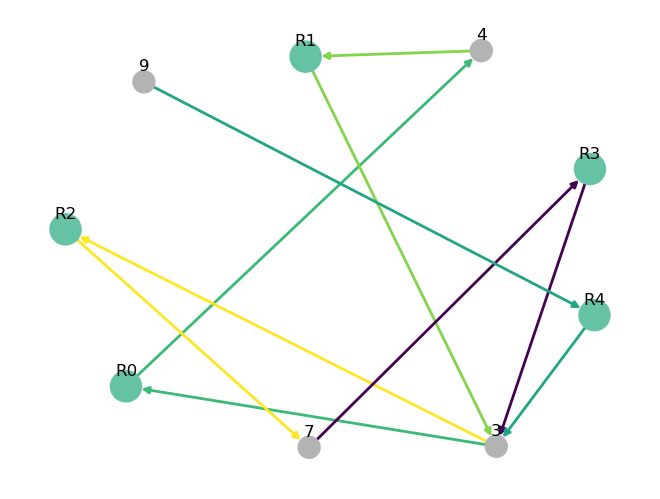

In [144]:
draw_graph(ass_rules_user_group, 5)

In [ ]:
plt.figure(figsize=(10,6))

plt.bar(rfm_counts_segment['RFM_segment'], rfm_counts_segment['count'],\
         color = my_cmap(rescale(rfm_counts_segment['RFM_score'] )))


plt.xlabel("RFM segment", size=18)
plt.ylabel("Cluents number", size=18)

plt.yticks(size=16)


plt.xticks(rfm_counts_segment['RFM_segment'],rfm_counts_segment['RFM_segment'], size=10, rotation = 90)
plt.grid(axis='y')
plt.title("RFM segments distribution",fontsize=20)

plt.show()

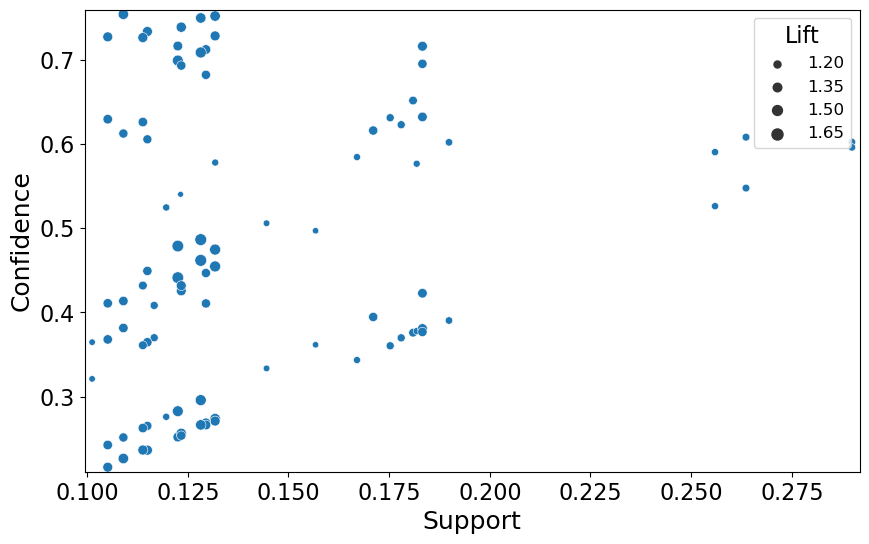

In [148]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = ass_rules_user_group)
plt.yticks(size=16)
plt.xticks(size=16)
plt.legend(fontsize = 12, title = 'Lift',title_fontsize = 16)
plt.xlabel("Support", size=18)
plt.ylabel("Confidence", size=18)
plt.margins(0.01,0.01)
plt.show()

# Text analysis

In [13]:
import spacy
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words

In [191]:
from wordcloud import WordCloud, STOPWORDS

In [15]:
reviews.head()

,review_id,customer_id,review_text
0,1,814256,I have bought several of the Vitality canned d...
1,2,457475,Product arrived labeled as Jumbo Salted Peanut...
2,3,104045,This is a confection that has been around a fe...
3,4,603662,If you are looking for the secret ingredient i...
4,5,739314,Great taffy at a great price. There was a wid...


In [16]:
labelles_reviews.head()


,labelled_reviews_index,review_text,sentiment_label
0,0,I'm no bitters expert but I bought it as a gif...,neutral
1,1,"these are probably great in the right drinks, ...",neutral
2,2,I sent these to my dad for his bday and he sai...,positive
3,3,I purchased these as a gift for family member ...,positive
4,4,My wife bought me this sauce sampler for Chris...,neutral


## Cleaning text data and preliminary analysis

In [22]:
cleaned_text = []
all_words = []
#labels_words = []
for text in tqdm(labelles_reviews['review_text']):
    sentence = nlp(text)
    lemmas = [word.lemma_ for word in sentence if \
        ((not nlp.vocab[word.lemma_].is_stop) and (not nlp.vocab[word.lemma_].is_punct) and (word.lemma_ != "/><br")) ]
    sentence_cleaned =' '.join(lemmas).strip()
    all_words.extend(lemmas)
    #labels_words.extend([labelles_reviews['sentiment_label'][i].tolist()[0]] * len (lemmas))
    cleaned_text.append(sentence_cleaned)

100%|██████████| 462744/462744 [1:28:50<00:00, 86.81it/s]  


In [23]:
labelles_reviews['text_cleaned'] = cleaned_text
labelles_reviews.to_csv('data/text_cleaned.csv')
#labelles_reviews = pd.read_csv('data/text_cleaned.csv')
#labelles_reviews = labelles_reviews.dropna()

In [209]:
#import pickle
#
#with open('data/results/all_words.pkl', 'wb') as f:
#  pickle.dump(all_words, f)
#
#with open('data/results/all_words.pkl', 'rb') as f:
#   mynewlist = pickle.load(f)

In [24]:
labelles_reviews['text_cleaned'] = labelles_reviews['text_cleaned'].str.replace('/><br', ' ', regex=True)
labelles_reviews['text_cleaned'] = labelles_reviews['text_cleaned'].str.replace('br', ' ', regex=True)
labelles_reviews['text_cleaned'] = labelles_reviews['text_cleaned'].str.replace('<', ' ', regex=True)
labelles_reviews['text_cleaned'] = labelles_reviews['text_cleaned'].str.replace('>', ' ', regex=True)
labelles_reviews['text_cleaned'] = labelles_reviews['text_cleaned'].str.replace('/', ' ', regex=True)

labelles_reviews['text_cleaned'] = labelles_reviews['text_cleaned'].str.strip()



In [34]:
text_positive =  " ".join(labelles_reviews[labelles_reviews['sentiment_label'] == 'positive']['text_cleaned'].tolist())
text_neutral =  " ".join(labelles_reviews[labelles_reviews['sentiment_label'] == 'neutral']['text_cleaned'].tolist())
text_negative =  " ".join(labelles_reviews[labelles_reviews['sentiment_label'] == 'negative']['text_cleaned'].tolist())

In [35]:
word_cloud_negative = WordCloud(
    width=3000,
    height=2000,
    random_state=1,
    colormap="viridis",
    collocations=False,
    stopwords=STOPWORDS,
    ).generate(text_negative)

In [264]:
word_cloud_positive = WordCloud(
    width=3000,
    height=2000,
    random_state=1,
    background_color="salmon",
    
    colormap="Pastel2",
    collocations=False,
    stopwords=STOPWORDS,
    ).generate(text_positive)

In [265]:
word_cloud_neutral = WordCloud(
    width=3000,
    height=2000,
    random_state=1,
    background_color="skyblue",
    colormap="GnBu",
    collocations=False,
    stopwords=STOPWORDS,
    ).generate(text_neutral)

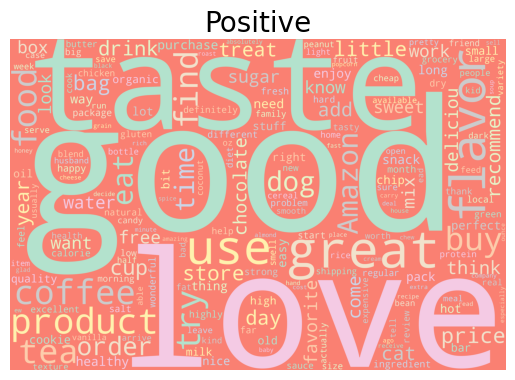

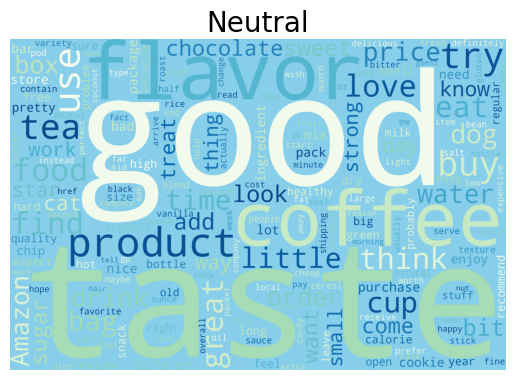

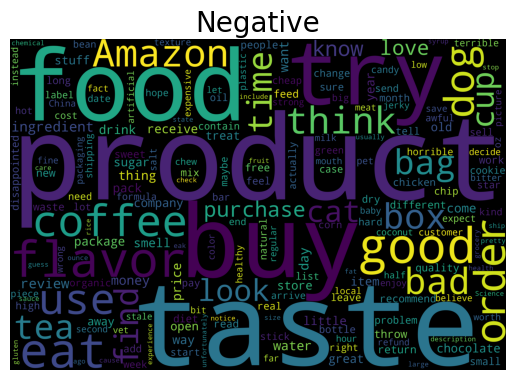

In [269]:
plt.imshow(word_cloud_positive)
plt.axis("off")
plt.title ('Positive', size = 20)
plt.show()

plt.imshow(word_cloud_neutral)
plt.axis("off")
plt.title ('Neutral', size = 20)
plt.show()

plt.imshow(word_cloud_negative)
plt.axis("off")
plt.title ('Negative', size = 20)
plt.show()

### Build predictive models

In [25]:
from sklearn.preprocessing import LabelEncoder
le_text = LabelEncoder()

labelles_reviews['class'] = le_text.fit_transform(labelles_reviews['sentiment_label'])

In [26]:
from sklearn.model_selection import train_test_split
data_text_train, data_text_test = train_test_split(labelles_reviews, test_size=0.3, random_state=42, stratify=labelles_reviews['class'] )

X_train_raw = data_text_train['text_cleaned']
y_train = data_text_train['class']

X_test_raw = data_text_test['text_cleaned']
y_test = data_text_test['class']


#### TF-IDF based predictions

##### NB

In [192]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


In [281]:
# Tf-Idf transform
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(X_train_raw)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(X_test_raw)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [282]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [283]:
y_pred_train_NB = clf.predict(X_train_tfidf)
y_pred_test_NB = clf.predict(X_test_tfidf)

In [194]:
from sklearn.metrics import accuracy_score


In [284]:
from sklearn.metrics import accuracy_score
print('train NB accuracy = ',accuracy_score(y_train, y_pred_train_NB))

print('test NB accuracy = ',accuracy_score(y_test, y_pred_test_NB))


train NB accuracy =  0.6978729315880464
test NB accuracy =  0.6850112372500432


#### XGboost

In [195]:
import xgboost as xgb

In [301]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [289]:
y_pred_train_xgb = model_xgb.predict(X_train_tfidf)
y_pred_test_xgb = model_xgb.predict(X_test_tfidf)

In [290]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(random_state=42)

In [291]:
y_pred_train_dtr = tree.predict(X_train_tfidf)
y_pred_test_dtr = tree.predict(X_test_tfidf)

In [292]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [293]:
y_pred_train_mlp = rfc.predict(X_train_tfidf)
y_pred_test_mlp = rfc.predict(X_test_tfidf)

In [296]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression(random_state=42).fit(X_train_tfidf, y_train)
 

In [297]:
y_pred_train_log = clf_log.predict(X_train_tfidf)
y_pred_test_log = clf_log.predict(X_test_tfidf)

In [299]:
models = ['NB', 'Xgb', 'DT', 'RF', 'Log']

accuracy_train = [accuracy_score(y_train, y_pred_train_NB),
    accuracy_score(y_train, y_pred_train_xgb),
    accuracy_score(y_train, y_pred_train_dtr),
    accuracy_score(y_train, y_pred_train_mlp),
    accuracy_score(y_train, y_pred_train_log)
                ]

accuracy_test = [accuracy_score(y_test, y_pred_test_NB),
    accuracy_score(y_test, y_pred_test_xgb),
    accuracy_score(y_test, y_pred_test_dtr),
    accuracy_score(y_test, y_pred_test_mlp),
    accuracy_score(y_test, y_pred_test_log)
                ]

time_train = [0.0, 1.8, 15.1, 40.5, 0.0 ]

In [199]:
import pickle

#with open('data/results/accuracy_train.pkl', 'wb') as f:
#  pickle.dump(accuracy_train, f)
#
#
#with open('data/results/accuracy_test.pkl', 'wb') as f:
#  pickle.dump(accuracy_test, f)
#

In [159]:
#with open('data/results/accuracy_test.pkl', 'rb') as f:
#   accuracy_test = pickle.load(f)
#
#with open('data/results/accuracy_train.pkl', 'rb') as f:
#   accuracy_train = pickle.load(f)

In [161]:
time_train = [0.0, 1.8, 15.1, 40.5, 0.0 ]
models = ['NB', 'Xgb', 'DT', 'RF', 'Log']


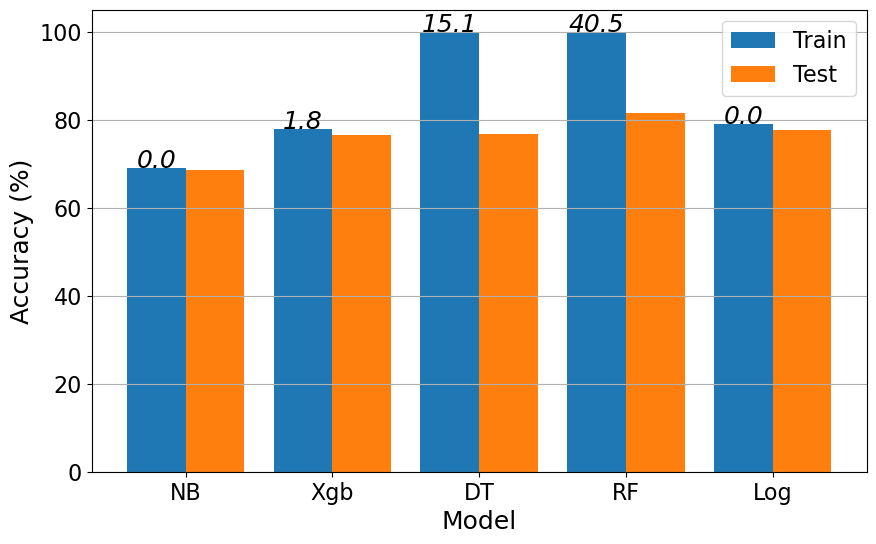

In [166]:
plt.figure(figsize=(10,6))
x = np.arange(len(models))

plt.bar(x-0.2, [i * 100 for i in accuracy_train], width = 0.4)
plt.bar(x+0.2, [i * 100 for i in accuracy_test], width = 0.4)

for i in range(len(x)):
    plt.text(x[i]-0.2, [i * 100 for i in accuracy_train][i], str(time_train[i]), horizontalalignment='center', style='italic', size=18)
#    plt.text(x[i]+0.2, (models_comparison['accuracy_test'] - models_comparison['naive_test'])[i], str(int(round(models_comparison['accuracy_test'][i],2)*100)) + '%', horizontalalignment='center', style='italic', size=18)

plt.xticks(x, models, size=16)
plt.yticks(size=16)

plt.xlabel("Model", size=18)
plt.ylabel("Accuracy (%)", size=18)
plt.grid(axis='y')
plt.legend(["Train", "Test"], fontsize=16)

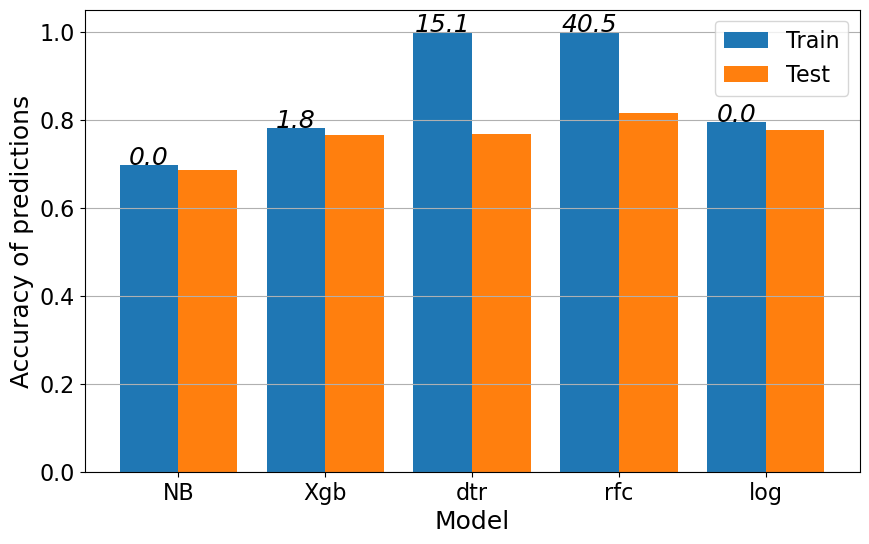

In [307]:
plt.figure(figsize=(10,6))
x = np.arange(len(models))

plt.bar(x-0.2, accuracy_train, width = 0.4)
plt.bar(x+0.2, accuracy_test, width = 0.4)

for i in range(len(x)):
    plt.text(x[i]-0.2, (accuracy_train)[i], str(time_train[i]), horizontalalignment='center', style='italic', size=18)
#    plt.text(x[i]+0.2, (models_comparison['accuracy_test'] - models_comparison['naive_test'])[i], str(int(round(models_comparison['accuracy_test'][i],2)*100)) + '%', horizontalalignment='center', style='italic', size=18)

plt.xticks(x, models, size=16)
plt.yticks(size=16)

plt.xlabel("Model", size=18)
plt.ylabel("Accuracy of predictions", size=18)
plt.grid(axis='y')
plt.legend(["Train", "Test"], fontsize=16)

### BERT Pretrained (collab file)

In [206]:
statistics.__version__

AttributeError: module 'statistics' has no attribute '__version__'

In [214]:
random.__version__

AttributeError: module 'random' has no attribute '__version__'

In [213]:
import random